In [3]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
from camera_intrinsic import mtx
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[[490.36443796   0.         303.34425126]
 [  0.         654.59356534 227.86422803]
 [  0.           0.           1.        ]]
Tiefenkarte erfolgreich gespeichert: C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\Tiefenkarten\20250105_164600_DepthMap.tiff
Tiefenkarte erfolgreich gespeichert: C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten\IMG_8173_DepthMap.jpg


# Standard Variablen
Hier definieren, extrahieren und verarbeiten wir die Tiefenkarten und RGB-Bilder des Samsung s20+ und des Iphone 14 und vergliechen diese miteinander.
Es kann aber hier schon erwähnt werden, dass die Erstellung der Punktewolke und jede weitere Verarbeitung mit den Bildern des Iphone 14 stattfindet, da die Bilder deutlich präziser sind.  

## Tiefenkarte und RGB-Daten extrahieren

IPhone Daten

In [4]:
url_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IphoneTestBilder\IMG_8173.jpg"
output_dir_Iphone = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten"

rgb_url_Iphone, depth_url_Iphone = transform_jpeg_to_depthmap_iphone(url_Iphone, output_dir_Iphone) #Nutzung unserer Funktion

#Open Images
depth_im_Iphone = Image.open(depth_url_Iphone)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Iphone = Image.open(rgb_url_Iphone)

Tiefenkarte erfolgreich gespeichert: C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\IPhoneTiefenkarten\IMG_8173_DepthMap.jpg


Samsung Daten

In [11]:
url_Samsung = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\SamsungTestBilder\20250105_164600.jpg"
output_dir_Samsung = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\SamsungTiefenkarten"

rgb_url_Samsung, depth_url_Samsung = transform_jpeg_to_depthmap_samsungs20(url_Samsung, output_dir_Samsung) #Nutzung unserer Funktion

#Open Images
depth_im_Samsung = Image.open(depth_url_Samsung)  # Quelle: https://stackoverflow.com/a/67346474
rgb_im_Samsung = Image.open(rgb_url_Samsung)

Tiefenkarte erfolgreich gespeichert: C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\SamsungTiefenkarten\20250105_164600_DepthMap.tiff


In [12]:

# print(depth_min, depth_max)
# print(depth_array)  # ggf. herausfinden, in welcher einheit die Entfernung angegeben ist (cm, mm, etc. ?) -> vermutlich cm?

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [22]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height

Resize Iphone RGB Image

In [23]:
rgb_im_Iphone, dm_width_Iphone, dm_height_Iphone = resize(rgb_im_Iphone, depth_im_Iphone)

dm_height:768, dm_width:576
 rgb_height:768, rgb_width:576
new_rgb_height:768, new_rgb_width:576


Resize Samsung RGB Image

In [15]:
rgb_im_Samsung = resize(rgb_im_Samsung, depth_im_Samsung)

dm_height:756, dm_width:1008
 rgb_height:3024, rgb_width:4032
new_rgb_height:756, new_rgb_width:1008


Getting the images as numpy arrays for later use

Iphone array

In [16]:
depth_array_Iphone = np.array(depth_im_Iphone)  # getting the depthmap as a numpy array
rgb_array_Iphone = np.array(rgb_im_Iphone)  # getting the rgb image as a numpy array

Samsung array

In [17]:
depth_array_Samsung = np.array(depth_im_Samsung)  # getting the depthmap as a numpy array
rgb_array_Samsung = np.array(rgb_im_Samsung)  # getting the rgb image as a numpy array

We need the images as open3d objects or else we can´t create the RGBD image

In [19]:
# convert the arrays to open3d objects Quelle: https://stackoverflow.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array
rgb_o3d = o3d.geometry.Image(rgb_array_Iphone)
depth_o3d = o3d.geometry.Image(depth_array_Iphone)
#depth_3d = o3d.geometry.Image(np.ascontiguousarray(depth_array_Iphone))

# Visualizing depth map

Plotting the depthmap

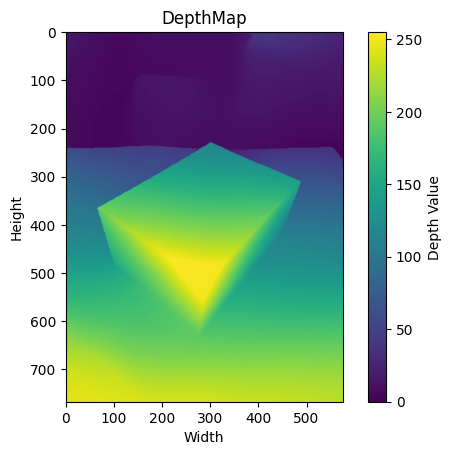

In [18]:
# plotting the depthmap
plt.imshow(depth_array_Iphone)
plt.colorbar(label="Depth Value")
plt.title("DepthMap")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


### Processing Depth Map

Normalisierung

In [ ]:
#depth_array = cv2.normalize(depth_array, None, 0, 255, cv2.NORM_MINMAX)

Filterung

# Create RGBD image

iPhone RGBD Image

In [28]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array

Comparison of RGB and depth map image

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Farbbild")
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title("Tiefenbild")
plt.imshow(rgbd.depth)
plt.show()

# Creating point cloud

## Get camera intrinsics

With the intrinsics of the camera that took the photo we are able to correct distortions 

In [20]:
# TODO: IPhone Intrinsics ehralten
fx = mtx[0, 0]
fy = mtx[1, 1]
cx = mtx[0, 2]
cy = mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


fx: 490.36443795915176, fy: 654.5935653359959, cx: 303.34425126266086, cy: 227.86422803169154


In [25]:
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    dm_width_Iphone, 
    dm_height_Iphone, 
    fx,  # Fokuslänge x
    fy,  # Fokuslänge y
    cx,  # optisches Zentrum x
    cy   # optisches Zentrum y
)


## Point cloud only from depth image

In [26]:
#depth image von uint8 zu uint16, da sonst die Funktion "o3d.geometry.PointCloud.create_from_depth_image" nicht funktioniert. Quelle: https://www.open3d.org/docs/latest/python_api/open3d.geometry.PointCloud.html
depth_data_uint16 = (depth_array_Iphone.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d = o3d.geometry.Image(depth_data_uint16)

# Erstelle eine Point Cloud aus dem Tiefenbild
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_uint16_o3d,
    intrinsic
)

In [27]:
o3d.visualization.draw_geometries([pcd])

## Point cloud only from RGBD image

In [29]:
pcrgbd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
o3d.visualization.draw_geometries([pcrgbd])

# Clean Point Cloud

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [30]:
pcd_center = pcd.get_center()
pcd.translate(pcd_center)

PointCloud with 442321 points.

## Statistical oulier removal
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [31]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [32]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=3.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [33]:
display_inlier_outlier(pcd, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [34]:
# Cleaned PC
pcd = pcd.select_by_index(ind)  # Nur Inlier

Visualizing the new PC

In [35]:
o3d.visualization.draw_geometries([pcd])

## Voxelization

In [ ]:
downpcd = pcrgbd.voxel_down_sample(voxel_size=0.0000005)
o3d.visualization.draw_geometries([downpcd])

### Plane segmentation

In [ ]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.01,
    ransac_n=5,
    num_iterations=1000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

# Inlier- und Outlier-Punktwolken
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud = inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
o3d.visualization.draw_geometries(
    [inlier_cloud, outlier_cloud])


### Hidden point removal

# Sonstiges

## Convex Hull
Die Konvexe Hülle wird ggf. relevant für die Volumenberechnung, sobald ich nur das Zielobjekt extrahieren kann. Problem ist nur bei dieser Methode, dass bspw. runde Objekte überschätzt werden. 

In [ ]:
# Berechnung der konvexen Hülle
hull_mesh, hull_vertices = pcd.compute_convex_hull()

# Erstellen eines Line-Sets aus dem konvexen Hüll-Mesh
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

# Farbe der konvexen Hülle setzen
hull_ls.paint_uniform_color([1, 0, 0])

# Visualisierung: Punktwolke und konvexe Hülle
o3d.visualization.draw_geometries([pcd, hull_ls])


In [ ]:
# DBSCAN-Clustering
# eps = 0.02  # Radius für Nachbarn
# min_points = 50  # Mindestanzahl von Punkten in einem Cluster
# labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))
# 
# # Anzahl der Cluster anzeigen
# num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# print(f"Anzahl der Cluster: {num_clusters}")
# 
# # Cluster visualisieren (Farben zuweisen)
# colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
# colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
# pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
# 
# # Visualisierung
# o3d.visualization.draw_geometries([pcd])

In [ ]:
# Punktwolke interaktiv anzeigen
print("Drücke 'Shift + Linksklick', um Punkte auszuwählen, und 'Shift + Rechtsklick', um Auswahl aufzuheben.")
picked_points = o3d.visualization.draw_geometries_with_editing([pcd])

# Ausgewählte Punkt-Indizes anzeigen
print(f"Ausgewählte Punkt-Indizes: {picked_points}")

In [ ]:
print(picked_points)

In [ ]:
import numpy as np

# Koordinaten der Punkte
point1 = np.array([0.075, 0.013, 0.24])  # Punkt 1 (#250552)
point2 = np.array([0.018, 0.019, 0.29])  # Punkt 2 (#52765)

# Euklidische Distanz berechnen
distance = np.linalg.norm(point2 - point1)

# Ergebnis ausgeben
print(f"Abstand zwischen den Punkten: {distance:.6f} Einheiten")
